In [68]:
# Load basic dependencies:
import warnings
warnings.filterwarnings('ignore')
import time
import csv

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

# Load Keras dependencies:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import PixelAttack, TargetedUniversalPerturbation
from art.defences.preprocessor import SpatialSmoothing
from art.utils import to_categorical

# Install ImageNet stubs:
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [3]:
images_list = list()
image_labels=list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    image_labels.append(image_path[image_path.rfind('/')+1:image_path.rfind('.')].replace('_',' '))
    if 'unicycle.jpg' in image_path:
        # get unicycle index
        unicycle_idx = i
images = np.array(images_list)

In [4]:
print(image_labels)

['manhole cover', 'bagel', 'rock crab', 'notebook computer', 'standard poodle', 'beagle', 'sleeping bag', 'flagpole', 'koala', 'gazelle', 'malamute', 'tractor', 'unicycle', 'marmoset', 'centipede', 'mitten']


In [5]:
print('Number of images:', images.shape[0])
print('Dimension of images:', images.shape[1], 'x', images.shape[2], 'pixels')
print('Number of color channels:', images.shape[3], '(RGB)')

Number of images: 16
Dimension of images: 224 x 224 pixels
Number of color channels: 3 (RGB)


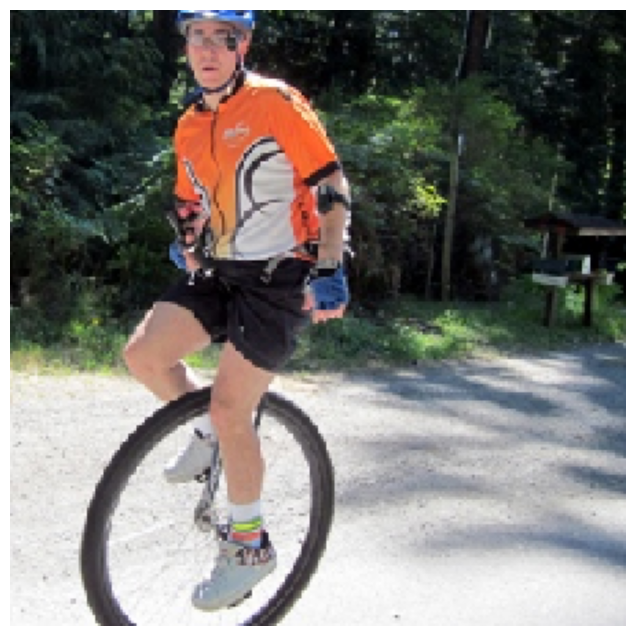

In [6]:
idx = unicycle_idx

plt.figure(figsize=(8,8)); plt.imshow(images[idx] / 255); plt.axis('off'); plt.show()

In [7]:
for i in range(1000):
    print('label', i, '-', label_to_name(i))

label 0 - tench, Tinca tinca
label 1 - goldfish, Carassius auratus
label 2 - great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
label 3 - tiger shark, Galeocerdo cuvieri
label 4 - hammerhead, hammerhead shark
label 5 - electric ray, crampfish, numbfish, torpedo
label 6 - stingray
label 7 - cock
label 8 - hen
label 9 - ostrich, Struthio camelus
label 10 - brambling, Fringilla montifringilla
label 11 - goldfinch, Carduelis carduelis
label 12 - house finch, linnet, Carpodacus mexicanus
label 13 - junco, snowbird
label 14 - indigo bunting, indigo finch, indigo bird, Passerina cyanea
label 15 - robin, American robin, Turdus migratorius
label 16 - bulbul
label 17 - jay
label 18 - magpie
label 19 - chickadee
label 20 - water ouzel, dipper
label 21 - kite
label 22 - bald eagle, American eagle, Haliaeetus leucocephalus
label 23 - vulture
label 24 - great grey owl, great gray owl, Strix nebulosa
label 25 - European fire salamander, Salamandra salamandra
label 26 

In [8]:
target_label = 94

In [9]:
x_art = np.expand_dims(images[idx], axis=0)

In [10]:
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


2023-03-04 22:21:15.285531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-04 22:21:15.581300: W tensorflow/c/c_api.cc:291] Operation '{name:'conv4_block6_3_bn/beta/Assign' id:3098 op device:{requested: '', assigned: ''} def:{{{node conv4_block6_3_bn/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv4_block6_3_bn/beta, conv4_block6_3_bn/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [66]:
from art.preprocessing.preprocessing import Preprocessor

class ResNet50Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1] 

In [65]:
preprocessor = ResNet50Preprocessor()

In [57]:
normalclassifier=KerasClassifier(model,clip_values=(0, 255), preprocessing=preprocessor)

Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.


In [12]:
import cv2

def reduce_resolution(img, resolution_percentage):
    # Extract the height, width, and channels from the input array
    height, width, channels = img.shape[1:]
    # Calculate the new height and width based on the input resolution percentage
    new_height = int(height * resolution_percentage / 100)
    new_width = int(width * resolution_percentage / 100)
    # Resize the image
    img_resized = cv2.resize(img[0], (new_width, new_height), interpolation=cv2.INTER_AREA)
    # Resize back to original size
    img_resized_back = cv2.resize(img_resized, (width, height), interpolation=cv2.INTER_AREA)
    # Reshape the output to match the input shape
    img_resized_back = np.expand_dims(img_resized_back, axis=0)
    return img_resized_back

In [13]:
class BetterClassifier(KerasClassifier):
        
    def predict(
        self, x: np.ndarray, batch_size: int = 128, training_mode: bool = False, **kwargs
    ) -> np.ndarray:
        """
        Perform prediction for a batch of inputs.

        :param x: Input samples.
        :param batch_size: Size of batches.
        :param training_mode: `True` for model set to training mode and `'False` for model set to evaluation mode.
        :return: Array of predictions of shape `(nb_inputs, nb_classes)`.
        """
        # Apply preprocessing
        x_preprocessed, _ = self._apply_preprocessing(x, y=None, fit=False)

        # Create containers for our predictions and spatial smoothening window sizes
        prediction_labels=[]
        prediction_scores=[]
        label_counts={}
        smoothening_values=[np.random.randint(70,99) for i in range(10)]
        
        #Predict with each window size, and store the labels and prediction scores in their containers
        for i in smoothening_values:
            x_def=reduce_resolution(img=x_preprocessed,resolution_percentage=i)
            pred = self._model.predict(x_def,batch_size=batch_size)
            label = label_to_name(np.argmax(pred, axis=1)[0])
            prediction_scores.append(pred)
            prediction_labels.append(label)
        
        #finding out which label is most frequently identified, and taking a weighted mean of that label's scores
        for label in prediction_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
                
        most_frequent_label = max(label_counts, key=label_counts.get)
        most_frequent_indexes = [i for i, p in enumerate(prediction_labels) if p == most_frequent_label]
        most_frequent_pred_scores = [prediction_scores[i] for i in most_frequent_indexes]

        weights = 1/np.array([smoothening_values[i] for i in most_frequent_indexes])
        predictions = np.average(most_frequent_pred_scores,axis=0,weights=weights)
        
        # Apply postprocessing
        predictions = self._apply_postprocessing(preds=predictions, fit=False)

        return predictions

In [58]:
betterclassifier = BetterClassifier(model,clip_values=(0, 255), preprocessing=preprocessor)

Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.


In [15]:
class BetterClassifierWithoutRandom(KerasClassifier):
        
    def predict(
        self, x: np.ndarray, batch_size: int = 128, training_mode: bool = False, **kwargs
    ) -> np.ndarray:
        """
        Perform prediction for a batch of inputs.

        :param x: Input samples.
        :param batch_size: Size of batches.
        :param training_mode: `True` for model set to training mode and `'False` for model set to evaluation mode.
        :return: Array of predictions of shape `(nb_inputs, nb_classes)`.
        """
        # Apply preprocessing
        x_preprocessed, _ = self._apply_preprocessing(x, y=None, fit=False)

        # Create containers for our predictions and spatial smoothening window sizes
        prediction_labels=[]
        prediction_scores=[]
        label_counts={}
        smoothening_values=[99,97,95,93,91,89,87,85,83,81]
        
        #Predict with each window size, and store the labels and prediction scores in their containers
        for i in smoothening_values:
            x_def=reduce_resolution(img=x_preprocessed,resolution_percentage=i)
            pred = self._model.predict(x_def,batch_size=batch_size)
            label = label_to_name(np.argmax(pred, axis=1)[0])
            prediction_scores.append(pred)
            prediction_labels.append(label)
        
        #finding out which label is most frequently identified, and taking a weighted mean of that label's scores
        for label in prediction_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
                
        most_frequent_label = max(label_counts, key=label_counts.get)
        most_frequent_indexes = [i for i, p in enumerate(prediction_labels) if p == most_frequent_label]
        most_frequent_pred_scores = [prediction_scores[i] for i in most_frequent_indexes]

        weights = 1/np.array([smoothening_values[i] for i in most_frequent_indexes])
        predictions = np.average(most_frequent_pred_scores,axis=0,weights=weights)
        
        # Apply postprocessing
        predictions = self._apply_postprocessing(preds=predictions, fit=False)

        return predictions

In [59]:
betterclassifierwithoutrandom = BetterClassifierWithoutRandom(model,clip_values=(0, 255), preprocessing=preprocessor)

Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.


In [60]:
attack1=ProjectedGradientDescent(normalclassifier, targeted=True, max_iter=10, eps_step=1, eps=5)

In [61]:
attack2=ProjectedGradientDescent(betterclassifierwithoutrandom, targeted=True, max_iter=10, eps_step=1, eps=5)

In [62]:
attack3=ProjectedGradientDescent(betterclassifier, targeted=True, max_iter=4, eps_step=10, eps=5)

In [69]:
def test(attack1,attack2,attack3,imageset):
    totaltime=time.time()
    file=open('testresult.csv', 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(['INPUT_IMG','NORM_CLAS_ORIG_IMG','NCOI_CONF','NCOI_RSLT','NCOI_TIME','NORM_CLAS_ADV_IMG','NCAI_CONF','NCAI_L_0','NCAI_L_1','NCAI_L_2','NCAI_L_INF','NCAI_RSLT','NCAI_TIME','BET_CLAS_NO_RAND_OG_IMG','BCNROI_CONF','BCNROI_RSLT','BCNROI_TIME','BET_CLAS_NO_RAND_ADV_IMG','BCNRAI_CONF','BCNRAI_L_0','BCNRAI_L_1','BCNRAI_L_2','BCNRAI_L_INF','BCNRAI_RSLT','BCNRAI_TIME','BET_CLAS_OG_IMG','BCOI_CONF','BCOI_RSLT','BCOI_TIME','BET_CLAS_ADV_IMG','BCAI_CONF','BCAI_L_0','BCAI_L_1','BCAI_L_2','BCAI_L_INF','BCAI_RSLT','BCAI_TIME'])

    for i,image_label in enumerate(imageset):
        x_art = np.expand_dims(imageset[i], axis=0)
        
        #normal classifier on original image
        time1_1=time.time()
        pred1_1=normalclassifier.predict(x_art)
        time1_1=time.time() - time1_1
        label1_1=np.argmax(pred1_1,axis=1)[0]
        confidence1_1=pred1_1[:,label1_1][0]
        if image_labels[i] in label_to_name(label1_1):
            result1_1='correct'
        elif label_to_name(target_label) in label_to_name(label1_1):
            result1_1='adversarial'
        else: result1_1='incorrect'
        
        #normal classifier on adversarial image
        x_art_adv1 = attack1.generate(x_art,y=to_categorical([target_label]))
        time1_2=time.time()
        pred1_2=normalclassifier.predict(x_art_adv1)
        time1_2=time.time() - time1_2
        label1_2=np.argmax(pred1_2,axis=1)[0]
        confidence1_2=pred1_2[:,label1_2][0]
        l_0_1_2 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv1[0])>0.5)[0]) / (224*224*3)) + 1   
        l_1_1_2 = int(99*np.sum(np.abs(x_art[0] - x_art_adv1[0])) / np.sum(np.abs(x_art[0]))) + 1
        l_2_1_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv1[0]) / np.linalg.norm(x_art[0])) + 1 
        l_inf_1_2 = int(99*np.max(np.abs(x_art[0] - x_art_adv1[0])) / 255) + 1
        if image_labels[i] in label_to_name(label1_2):
            result1_2='correct'
        elif label_to_name(target_label) in label_to_name(label1_2):
            result1_2='adversarial'
        else: result1_2='incorrect'
        
        #better classifier without randomness on original image
        time2_1=time.time()
        pred2_1=betterclassifierwithoutrandom.predict(x_art)
        time2_1=time.time() - time2_1
        label2_1=np.argmax(pred2_1,axis=1)[0]
        confidence2_1=pred2_1[:,label2_1][0]
        if image_labels[i] in label_to_name(label2_1):
            result2_1='correct'
        elif label_to_name(target_label) in label_to_name(label2_1):
            result2_1='adversarial'
        else: result2_1='incorrect'
        
        #better classifier without randomness on adversarial image
        x_art_adv2 = attack2.generate(x_art,y=to_categorical([target_label]))
        time2_2=time.time()
        pred2_2=betterclassifierwithoutrandom.predict(x_art_adv2)
        time2_2=time.time() - time2_2
        label2_2=np.argmax(pred2_2,axis=1)[0]
        confidence2_2=pred2_2[:,label2_2][0]
        l_0_2_2 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv2[0])>0.5)[0]) / (224*224*3)) + 1   
        l_1_2_2 = int(99*np.sum(np.abs(x_art[0] - x_art_adv2[0])) / np.sum(np.abs(x_art[0]))) + 1
        l_2_2_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv2[0]) / np.linalg.norm(x_art[0])) + 1 
        l_inf_2_2 = int(99*np.max(np.abs(x_art[0] - x_art_adv2[0])) / 255) + 1
        if image_labels[i] in label_to_name(label2_2):
            result2_2='correct'
        elif label_to_name(target_label) in label_to_name(label2_2):
            result2_2='adversarial'
        else: result2_2='incorrect'
        
        #better classifier on original image
        time3_1=time.time()
        pred3_1=betterclassifier.predict(x_art)
        time3_1=time.time() - time3_1
        label3_1=np.argmax(pred3_1,axis=1)[0]
        confidence3_1=pred3_1[:,label3_1][0]
        if image_labels[i] in label_to_name(label3_1):
            result3_1='correct'
        elif label_to_name(target_label) in label_to_name(label3_1):
            result3_1='adversarial'
        else: result3_1='incorrect'
        
        #better classifier on adversarial image
        x_art_adv3 = attack3.generate(x_art,y=to_categorical([target_label]))
        time3_2=time.time()
        pred3_2=betterclassifier.predict(x_art_adv3)
        time3_2=time.time() - time3_2
        label3_2=np.argmax(pred3_2,axis=1)[0]
        confidence3_2=pred3_2[:,label3_2][0]
        l_0_3_2 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv3[0])>0.5)[0]) / (224*224*3)) + 1   
        l_1_3_2 = int(99*np.sum(np.abs(x_art[0] - x_art_adv3[0])) / np.sum(np.abs(x_art[0]))) + 1
        l_2_3_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv3[0]) / np.linalg.norm(x_art[0])) + 1 
        l_inf_3_2 = int(99*np.max(np.abs(x_art[0] - x_art_adv3[0])) / 255) + 1
        if image_labels[i] in label_to_name(label3_2):
            result3_2='correct'
        elif label_to_name(target_label) in label_to_name(label3_2):
            result3_2='adversarial'
        else: result3_2='incorrect'
        
        writer.writerow([image_labels[i],label_to_name(label1_1),'{0:.2f}'.format(confidence1_1),result1_1,time1_1,label_to_name(label1_2),'{0:.2f}'.format(confidence1_2),l_0_1_2,l_1_1_2,l_2_1_2,l_inf_1_2,result1_2,time1_2,label_to_name(label2_1),'{0:.2f}'.format(confidence2_1),result2_1,time2_1,label_to_name(label2_2),'{0:.2f}'.format(confidence2_2),l_0_2_2,l_1_2_2,l_2_2_2,l_inf_2_2,result2_2,time2_2,label_to_name(label3_1),'{0:.2f}'.format(confidence3_1),result3_1,time3_1,label_to_name(label3_2),'{0:.2f}'.format(confidence3_2),l_0_3_2,l_1_3_2,l_2_3_2,l_inf_3_2,result3_2,time3_2])
        print(i)
        
    file.close()

In [70]:
test(attack1,attack2,attack3,images)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

0


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

1


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

2


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

3


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

4


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

5


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

6


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

7


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

8


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

9


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

10


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

11


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

12


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

13


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

14


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

15


In [71]:
df=pd.read_csv('testresult.csv')

In [72]:
print(df)

            INPUT_IMG                                 NORM_CLAS_ORIG_IMG  \
0       manhole cover                                      manhole cover   
1               bagel                                      bagel, beigel   
2           rock crab                        rock crab, Cancer irroratus   
3   notebook computer                        notebook, notebook computer   
4     standard poodle                                    standard poodle   
5              beagle                                             beagle   
6        sleeping bag                                       sleeping bag   
7            flagpole                                flagpole, flagstaff   
8               koala  koala, koala bear, kangaroo bear, native bear,...   
9             gazelle                                            gazelle   
10           malamute               malamute, malemute, Alaskan malamute   
11            tractor                                            tractor   
12          

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   INPUT_IMG                 16 non-null     object 
 1   NORM_CLAS_ORIG_IMG        16 non-null     object 
 2   NCOI_CONF                 16 non-null     float64
 3   NCOI_RSLT                 16 non-null     object 
 4   NCOI_TIME                 16 non-null     float64
 5   NORM_CLAS_ADV_IMG         16 non-null     object 
 6   NCAI_CONF                 16 non-null     float64
 7   NCAI_L_0                  16 non-null     int64  
 8   NCAI_L_1                  16 non-null     int64  
 9   NCAI_L_2                  16 non-null     int64  
 10  NCAI_L_INF                16 non-null     int64  
 11  NCAI_RSLT                 16 non-null     object 
 12  NCAI_TIME                 16 non-null     float64
 13  BET_CLAS_NO_RAND_OG_IMG   16 non-null     object 
 14  BCNROI_CONF 